## 09. 회귀 실습 - 자전거 대여 수요 예측
캐글의 자전거 대여 수요(Bike Sharing Demand) 예측 경연에서 사용된 학습 데이터 세트를 이용해 선형 회귀와 트리 기반 회귀를 비교해 보겠다.

train.csv 파일을 내려받은 뒤에 bike_train.csv로 파일명을 변한니다. 해당 데이터 세트에는 2011년 1월부터 2012년 12월까지 날짜/시간, 기온, 습도, 풍속 등의 정보를 기반으로 1시간 간격 동안의 자전거 대여 횟수가 기재돼 있다. 결정 값은 맨 마지막 칼럼인 count로 '대여 횟수'를 의미한다.

### 데이터 클렌징 및 가공과 데이터 시각화
bike_train.csv 데이터 세트를 이용해 모델을 학습한 후 대여 횟수(count)를 예측해 보겠다. 새로운 주피터 노트북을 생성한 뒤, bike_train.csv를 해당 노트북이 생성된 디렉터리로 이동시킨다. 데이터 세트를 DataFrame으로 로드해 대략적으로 데이터를 확인해 보겠다.

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

bike_df = pd.read_csv('bike_train.csv')
print(bike_df.shape)
bike_df.head()

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


해당 데이터 세트는 10886개의 레코드와 12개의 칼럼으로 구성돼 있다. 데이터 칼럼의 타입을 살펴보겠다.

In [3]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


10886개의 로우(row) 데이터 중 Null 데이터는 없으며, 대부분의 칼럼이 int 또는 float 숫자형인데, datetime 칼럼만 object 형이다. Datetime 칼럼의 경우 년-월-일 시:분:초 문자 형식으로 돼 있으므로 이에 대한 가공이 필요하다. datetime을 년, 월, 일, 그리고 시간과 같이 4개의 속성으로 분리하겠다. 판다스에서는 datetime과 같은 형태의 문자열을 년도, 월, 일, 시간, 분, 초로 편리하게 변환하려면 먼저 문자열을 'datetime'타입으로 변경해야 한다. 판다스는 문자열을 datetime 타입으로 변환하는 apply(pd.to_datetime) 메서드를 제공한다. 이를 이용해 년, 월, 일, 시간 칼럼을 추출하겠다.

In [4]:
# 문자열을 datetime 타입으로 변경.
bike_df['datetime'] = bike_df.datetime.apply(pd.to_datetime)

# datetime 타입에서 년, 월, 일, 시간 추출
bike_df['year'] = bike_df.datetime.apply(lambda x : x.year)
bike_df['month'] = bike_df.datetime.apply(lambda x : x.month)
bike_df['day'] = bike_df.datetime.apply(lambda x : x.day)
bike_df['hour'] = bike_df.datetime.apply(lambda x : x.hour)
bike_df.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2


새롭게 year, month, day, hour 칼럼이 추가됐다. 이제 datetime 칼럼은 삭제하겠습다. 또한 casual 칼럼은 사전에 등록하지 않은 사용자의 자전거 대여 횟수이고, registered는 사전에 등록한 사용자의 대여 횟수이며, casual + registered = count이므로 casual과 registered가 따로 필요하지는 않다. 오히려 상관도가 높아 예측을 저해할 우려가 있으므로 이 두 칼럼도 삭제하겠다.

In [5]:
drop_columns = ['datetime', 'casual', 'registered']
bike_df.drop(drop_columns, axis=1, inplace=True)

이번에는 주요 칼럼별로 Target 값인 count(대여 횟수)가 어떻게 분포되어 있는지 시각화해보겠다. 총 8개의 칼럼인 'year','month','season','weather','day', 'hour', 'holiday','workingday'에 대해서 칼럼별 값에 따른 count의 합을 표현하기 위해서 시본의 barplot을 적용한다. 8개의 칼럼들을 한번에 시각화 하기 위해서 이전 'linearRegression을 이용해 보스턴 주택 가격 회귀 구현'실습 예제에서 사용하였던 matplotlib의 subplots()을 기반으로 barplot을 표현해 보겠다. 총 8개의 barplot을 그리기 위해 plt.subplots() 의 인자로 ncols=4, nrows=2를 입력하여 2개의 행과 4개의 열을 가진 그래프로 표현한다,

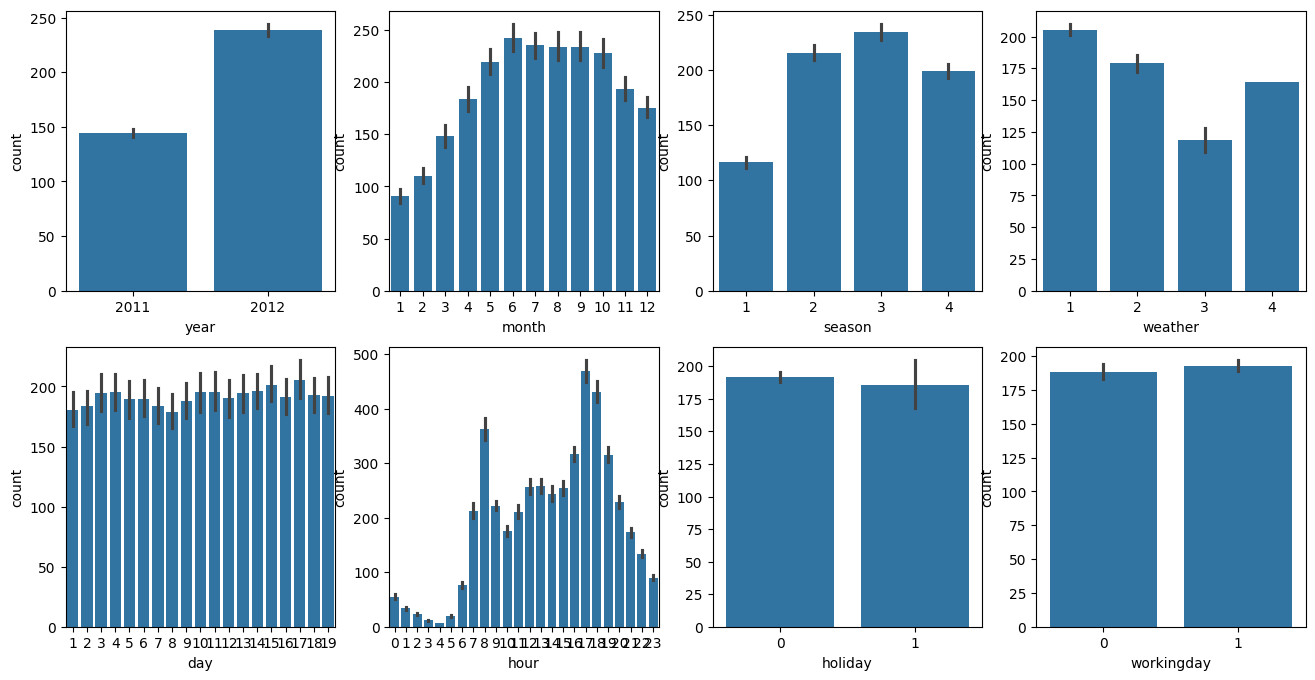

In [6]:
fig, axs = plt.subplots(figsize=(16,8), ncols=4, nrows=2)
cat_features = ['year','month','season','weather','day','hour','holiday','workingday']
# cat_features에 있는 모든 칼럼별로 개별 칼럼값에 따른 count의 합을 barplot으로 시각화
for i, feature in enumerate(cat_features):
  row = int(i/4)
  col = i%4
  # 시본의 barplot을 이용해 칼럼값에 따른 count의 합을 표현
  sns.barplot(x=feature, y='count', data=bike_df, ax=axs[row][col])

year(년도)별 count를 보면 2012년이 2011 년보다 상대적으로 값이 높다. 이는 year자체가 특별한 의미가 있어서라기보다는 시간이 지날수록 자전거 대여 횟수가 지속적으로 증가한 결과라고 여겨질 수 있다. month(월별)의 경우 1, 2, 3월이 낮고, 6, 7, 8, 9월이 높다. 또한 season(계절)을 보면 봄(1), 겨울(4)이 낮고, 여름(2), 가을(3)이 높다. weather(날씨)의 경우는 눈 또는 비가 있는 경우(3과 4)가 낮고, 맑거나(1) 약간 안개가 있는 경우(2)가 높다.

hour(시간)의 경우는 오전 출근 시간(8)과 오후 퇴근 시간(17, 18)이 상대적으로 높다. day(일자)간의 차이는 크지 않으며, holiday(휴일 여부) 또는 workingday(주중 여부)는 주중일 경우 (즉 holiday는 0, workingday는 1)가 상대적으로 약간 높다.

다음으로 다양한 회귀 모델을 데이터 세트에 적용해 예측 성능을 측정해 보겠다. 캐글에서 요구한 성능 평가 방법은 RMSLE(Root Mean Square Log Error)이다. 즉, 오류 값의 로그에 대한 RMSE이다. 아쉽게도 사이킷런은 RMSLE를 제공하지 않아서 RMSLE를 수행하는 성능 평가 함수를 직접 만들어 보겠다. RMSLE뿐만 아니라 MAE, RMSE까지 한꺼번에 평가하는 함수도 만들겠다.

In [15]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# log 값 변환 시 NaN 등의 이슈로 log()가 아닌 log1p()를 이용해 RMSLE 계산

def rmsle(y,pred):
  log_y = np.log1p(y)
  log_pred = np.log1p(pred)
  squared_error = (log_y - log_pred) ** 2
  rmsle = np.sqrt(np.mean(squared_error))
  return rmsle

# 사이킷런의 mean_squared_error()를 이용해 RMSLE 계산
def rmse(y,pred):
  return np.sqrt(mean_squared_error(y,pred))

# MAE, RMSE, RMSLE를 모두 계산
def evaluate_regr(y,pred):
  rmsle_val = rmsle(y,pred)
  rmse_val = rmse(y,pred)
  # MAE는 사이킷런의 mean_absolute_error()로 계산
  mae_val = mean_absolute_error(y,pred)
  print('RMSLE: {0:.3f}, RMSE: {1:.3f}, MAE: {2:.3f}'.format(rmsle_val, rmse_val, mae_val))

위의 rmsle() 함수를 만들 때 한 가지 주의해야 할 점이 있다. rmsle를 구할 때 넘파이의 log()함수를 이용하거나 사이킷런의 mean_squared_log_error()를 이용할 수도 있지만 데이터 값의 크기에 따라 오버플로/언더플로(overflow/underflow) 오류가 발생하기 쉽다. 예를 들어 rmsle()를 다음과 같이 정의했을 때 쉽게 오류가 발생할 수 있다.

In [8]:
# 다음과 같은 rmsle 구현은 오버플로나 언더플로 오류를 발생하기 쉽다.
def rmsel(y,pred):
  msle = mean_squared_log_error(y,pred)
  rmsle = np.sqrt(mse)
  return rmsle

따라서 log()보다는 log1p()를 사용하는데, log1p(x)의 경우는 log(1+x)로 변환되므로 x값이 0이 되더라도 log(0)인 무한대가 되지 않고, log(1)인 0이 되므로 오버플로/언더플로 문제를 해결해 준다. 그리고 log1p()로 변환된 값은 다시 넘파이의 expm1() 함수로 쉽게 원래의 스케일로 복원될 수 있다.

### 로그 변환, 피처 인코딩과 모델 학습/예측/평가
이제 회귀 모델을 이용해 자전거 대여 횟수를 예측해 보겠다. 회귀 모델을 적용하기 전에 데이터 세트에 대해서 먼저 처리해야 할 사항이 있다. 결괏값이 정규 분포로 돼 있는지 확인하는 것과 카테고리형 회귀 모델의 경우 원-핫 인코딩으로 피처를 인코딩하는 것이다. 회귀 모델을 적용하면서 이 두가지 사항을 확인해 보겠다.

먼저 사이킷런의 LinearRegression 객체를 이용해 회귀 예측을 하겠다.

In [9]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso

y_target = bike_df['count']
X_features = bike_df.drop(['count'], axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size = 0.3, random_state=0)

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

evalute_regr(y_test, pred)

RMSLE: 1.165, RMSE: 140.900, MAE: 105.924


RMSLE: 1.165, RMSE: 140.900, MAE: 105.924는 실제 Target 데이터 값인 대여 횟수(Count)를 감안하면 예측 오류로서는 비교적 큰 값이다. 실제 값과 예측값이 어느 정도 차이가 나는지 DataFrame의 칼럼으로 만들어서 오류 값이 가장 큰 순으로 5개만 확인해 보겠다.

In [11]:
def get_top_error_data(y_test, pred, n_tops=5):
  # DataFrame의 칼럼으로 실제 대여 횟수(Count)와 예측값을 서로 비교할 수 있도록 생성.
  result_df = pd.DataFrame(y_test.values, columns=['real_count'])
  result_df['predicted_count'] = np.round(pred)
  result_df['diff'] = np.abs(result_df['real_count'] - result_df['predicted_count'])

# 예측값과 실제 값이 가장 큰 데이터 순으로 출력
  print(result_df.sort_values('diff', ascending=False)[:n_tops])

get_top_error_data(y_test, pred, n_tops=5)

      real_count  predicted_count   diff
1618         890            322.0  568.0
966          884            327.0  557.0
3151         798            241.0  557.0
412          745            194.0  551.0
2817         856            310.0  546.0


가장 큰 상위 5위 오류 값은 546~568로 실제 값을 감안하면 예측 오류가 꽤 크다. 회귀에서 이렇게 큰 예측 오류가 발생할 경우 가장 먼저 살펴볼 것은 Target 값의 분포가 왜곡된 형태를 이루고 있는지 확인하는 것이다. Target 값의 분포는 정규 분포 형태가 가장 좋다. 그렇지 않고 왜곡된 경우에는 회귀 예측 성능이 저하되는 경우가 발생하기 쉽다. 판다스 DataFrame의 hist()를 이용해 자전거 대여 모델의 Target 값인 count 칼럼이 정규 분포를 이루는지 확인해 보겠다.

<Axes: >

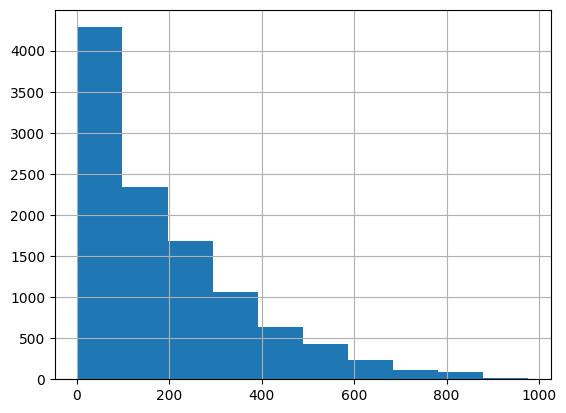

In [12]:
y_target.hist()

count 칼럼 값이 정규 분포가 아닌 0~200 사이에 왜곡돼 있는 것을 알 수 있다. 이렇게 왜곡된
값을 정규 분포 형태로 바꾸는 가장 일반적인 방법은 로그를 적용해 변환하는 것이다. 여기서는 넘
파이의 loglp()를 이용하겠다. 이렇게 변경된 Target 값을 기반으로 학습하고 예측한 값은 다시
expml() 함수를 적용해 원래 scale 값으로 원상 복구하면 된다. loglp()를 적용한 'count' 값의 분
포를 확인하겠다.

<Axes: >

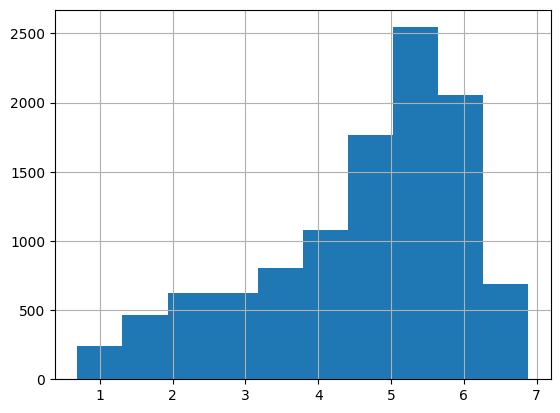

In [13]:
y_log_transform = np.log1p(y_target)
y_log_transform.hist()

로그로 Target 값을 변환한 후에 원하는 정규 분포 형태는 아니지만 변환하기 전보다는 왜곡 정도가 많이 향상됐다. 이를 이용해 다시 학습한 후 평가를 수행해 보겠다.

In [18]:
# 타깃 컬럼인 count 값을 log1p로 로그 변환
y_target_log = np.log1p(y_target)

# 로그 변환된 y_target_log를 반영해 학습/테스트 데이터 세트 분할
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target_log, test_size=0.3, random_state=0)

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

# 테스트 데이터 세트의 Target 값은 로그 변환됐으므로 다시 expm1을 이용해 원래 스케일로 변환
y_test_exp = np.expm1(y_test)

# 예측값 역시 로그 변환된 타깃 기반으로 학습돼 예측됐으므로 다시 expm1로 스케일 변환
pred_exp = np.expm1(pred)

evaluate_regr(y_test_exp, pred_exp)

RMSLE: 1.017, RMSE: 162.594, MAE: 109.286


RMSLE 오류는 줄어들었지만, RMSE는 오히려 더 늘어났다. 이번에는 개별 피처들의 인코딩을 적용해 보겠다. 먼저 각 피처의 회귀 계숫값을 시각화해보겠다.

<Axes: ylabel='None'>

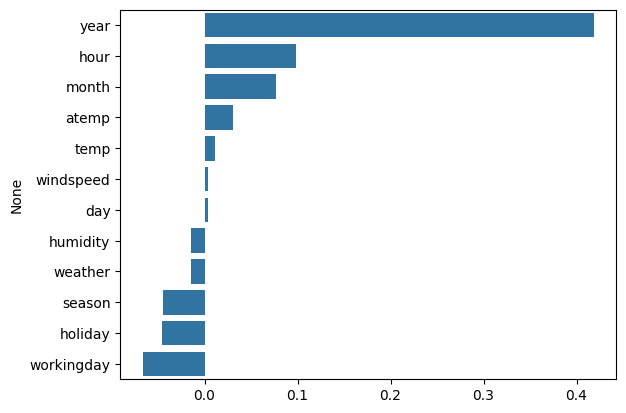

In [19]:
coef = pd.Series(lr_reg.coef_, index = X_features.columns)
coef_sort = coef.sort_values(ascending=False)
sns.barplot(x=coef_sort.values, y=coef_sort.index)

year, hour, month, season, holiday, workingday 피처들의 회귀 계수 영향도가 상대적으로 높다. 이들 피처들을 살펴보면 year는 2011, 2012 값으로, month는 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12와 같이 숫잣값 형태로 의미를 담고 있다. 하지만 이들 피처들의 경우 개별 숫자값의 크기가 의미가 있는 것이 아니다. Year의 경우 단순히 연도를 뜻하는 것이므로 2012라는 값이 2011보다 큰 값으로 인식되어서는 안 된다. 즉 year, hour, month 등은 숫자 값으로 표현되었지만 이들은 모두 카테고리(Category)형 피처이다.

사이킷런은 카테고리만을 위한 데이터 타입이 없으며, 모두 숫자로 변환해야 한다. 하지만 이처럼 숫자형 카테고리 값을 선형 회귀에 사용할 경우 회귀 계수를 연산할 때 이 숫자형 값에 크게 영향을 받는 경우가 발생할 수 있다. 따라서 선형 회귀에서는 이러한 피처 인코딩에 원-핫 인코딩을 적용해 변환해야 한다.

판다스의 get_dummies()를 이용해 이러한 yesr 칼럼을 비롯해 month, day, hour, holiday, workingday, season, weather 칼럼도 모두 원-핫 인코딩한 후에 다시 예측 성능을 확인해 보겠다.

In [20]:
# 'year','month', 'day', 'hour'등의 피처들을 One Hot Encoding
X_features_ohe = pd.get_dummies(X_features, columns=['year', 'month','day', 'hour', 'holiday', 'workingday','season','weather'])

사이킷런의 선형 회귀 모델인 LinearRegression, Ridge, Lasso 모두 학습해 예측 성능을 확인한다. 이를 위해 모델과 학습/테스트 데이터 세트를 입력하면 성능 평가 수치를 반환하는 get_model_predict() 함수를 만들겠다.

In [23]:
# 원-핫 인코딩이 적용된 피처 데이터 세트 기반으로 학습/예측 데이터 분할.
X_train, X_test, y_train, y_test = train_test_split(X_features_ohe, y_target_log, test_size=0.3, random_state=0)

# 모델과 학습/테스트 데이터 세트를 입력하면 성능 평가 수치를 반환
def get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=False):
  model.fit(X_train, y_train)
  pred = model.predict(X_test)
  if is_expm1:
    y_test = np.expm1(y_test)
    pred = np.expm1(pred)
  print( '###', model.__class__.__name__, '###')
  evaluate_regr(y_test, pred)
# end of function get_model_predict

# 모델별로 평가 수행
lr_reg = LinearRegression()
ridge_reg = Ridge(alpha=10)
lasso_reg = Lasso(alpha=0.01)

for model in [lr_reg, ridge_reg, lasso_reg]:
  get_model_predict(model,X_train, X_test, y_train, y_test,is_expm1=True)

### LinearRegression ###
RMSLE: 0.590, RMSE: 97.688, MAE: 63.382
### Ridge ###
RMSLE: 0.590, RMSE: 98.529, MAE: 63.893
### Lasso ###
RMSLE: 0.635, RMSE: 113.219, MAE: 72.803


원-핫 인코딩을 적용하고 나서 선형 회귀의 예측 성능이 많이 향상됐다. 원-핫 인코딩된 데이터 세트에서 회귀 계수가 높은 피처를 다시 시각화하겠다. 원-핫 인코딩으로 피처가 늘어났으므로 회귀 계수 상위 20개 피처를 추출해 보겠다.

<Axes: ylabel='None'>

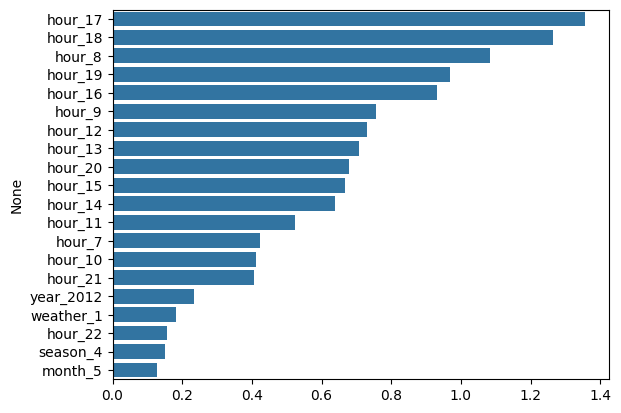

In [24]:
coef = pd.Series(lr_reg.coef_, index=X_features_ohe.columns)
coef_sort = coef.sort_values(ascending=False)[:20]
sns.barplot(x=coef_sort.values, y=coef_sort.index)

원-핫 인코딩 후에는 year_2012, year_2011 과 같이 여전히 year 관련 피처들의 회귀 계수 값이 가장 높지만, season_1과 같은 season 관련, weather_1, 2, 3, 4와 같은 weather 관련 속성들의 회귀 계수 값도 상대적으로 커졌다. 원-핫 인코딩을 통해서 피처들의 영향도가 달라졌고, 모델의 성능도 향상되었다. 반드시 그런 것은 아니지만 선형 회귀의 경우 중요 카테고리성 피처들을 원-핫 인코딩으로 변환하는 것은 성능에 중요한 영향을 미칠 수 있다.

이번에는 회귀 트리를 이용해 회귀 예측을 수행하겠다. 앞에서 적용한 Target 값의 로그 변환된 값과 원-핫 인코딩된 피처 데이터 세트를 그대로 이용해 랜덤 포레스트, GBM, XGBoost, LightGBM을 순차적으로 성능 평가해 보겠다. XGBoost의 경우 DataFrame이 학습/테스트 데이터로 입력될 경우 버전에 따라 오류가 발생할 수 있으므로 학습/테스트 데이터를 DataFrame의 values 속성을 이용해 넘파이 ndarray로 변환하겠다.

In [25]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# 랜덤 포레스트, GBM, XGboost, LightGBm model별로 평가 수행
rf_reg = RandomForestRegressor(n_estimators=500)
gb_reg = GradientBoostingRegressor(n_estimators=500)
xgb_reg = XGBRegressor(n_estimators=500)
lgb_reg = LGBMRegressor(n_estimators=500)

for model in [rf_reg, gb_reg, xgb_reg, lgb_reg]:
  # XGBoost의 경우 DataFrame이 입력될 경우 버전에 따라 오류 발생 가능. ndarray로 변환.
  get_model_predict(model, X_train.values, X_test.values, y_train.values, y_test.values, is_expm1=True)

### RandomForestRegressor ###
RMSLE: 0.354, RMSE: 50.446, MAE: 31.266
### GradientBoostingRegressor ###
RMSLE: 0.330, RMSE: 53.365, MAE: 32.752
### XGBRegressor ###
RMSLE: 0.339, RMSE: 51.475, MAE: 31.357
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001207 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 348
[LightGBM] [Info] Number of data points in the train set: 7620, number of used features: 72
[LightGBM] [Info] Start training from score 4.582043
### LGBMRegressor ###
RMSLE: 0.319, RMSE: 47.215, MAE: 29.029


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


앞의 선형 회귀 모델보다 회귀 예측 성능이 개선됐다. 하지만 이것이 회귀 트리가 선형 회귀보다 더 나은 성능을 가진다는 의미는 아니다. 데이터 세트의 유형에 따라 결과는 얼마든지 달라질 수 있다.

## 10. 회귀 실습 - 캐글 주택 가격: 고급 회귀 기법
이번 실습은 캐글에서 제공하는 캐글 주택 가격: 고급 회귀 기법(House Prices: Advanced Regression Techniques) 데이터 세트를 이용해 회귀 분석을 더 심층적으로 학습해 보겠다.

79개 변수로 구성된 이 데이터는 미국 아이오와 주의 에임스(Ames) 지방의 주택 가격 정보를 가지고 있다. 성능 평가는 앞의 자전거 대여 예측 예제와 동일한 RMSLE(Root Mean Squared Log Error)를 기반으로 한다. 가격이 비싼 주택일수록 예측 결과 오류가 전체 오류에 미치는 비중이 높으므로 이것을 상쇄하기 위해 오류 값을 로그 변환한 RMSLE를 이용한다.

### 데이터 사전 처리(Preprocessing)
새로운 주피터 노트북을 생성하고, 해당 노트북이 생성된 디렉터리에 house_price.csv를 이동한다. 먼저 필요한 모듈과 데이터를 로딩하고 개략적으로 데이터를 확인해 보겠다. 이 예제는 데이터 가공을 많이 수행할 예정이므로 원본 csv 파일 기반의 DataFrame은 보관하고 복사해서 데이터를 가공하겠다.

In [35]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

house_df_org = pd.read_csv('house_price.csv')
house_df = house_df_org.copy()
house_df.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


Target 값은 맨 마지막 칼럼인 SalePrice이다. 데이터 세트의 전체 크기와 칼럼의 타입, 그리고 Null이 있는 칼럼과 그 건수를 내림차순으로 출력해 보겠다.

In [36]:
print('데이터 세트의 Shape:', house_df.shape)
print('\n전체 피처의 type \n',house_df.dtypes.value_counts())
isnull_series = house_df.isnull().sum()
print('\nNull 칼럼과 그 건수:\n',isnull_series[isnull_series > 0].sort_values(ascending=False))

데이터 세트의 Shape: (1460, 81)

전체 피처의 type 
 object     43
int64      35
float64     3
Name: count, dtype: int64

Null 칼럼과 그 건수:
 PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtExposure      38
BsmtFinType2      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrArea         8
Electrical         1
dtype: int64


데이터 세트는 1460개의 레코드와 81개의 피처로 구성돼 있으며, 피처의 타입은 숫자형은 물론 문자형도 많이 있다. Target을 제외한 80개의 피처 중 43개가 문자형이며 나머지가 숫자형이다. 데이터 양에 비해 Null 값이 많은 피처도 있다. 전체 1480개 데이터 중 PoolQC, MiscFeature, Alley, Fence는 1000개가 넘는 데이터가 Null이다. Null 값이 너무 많은 피처는 드롭하겠다.

회귀 모델을 적용하기 전에 타깃 값의 분포도가 정규 분포인지 확인하겠다. 다음 그림에서 볼 수 있듯이 데이터 값의 분포가 중심에서 왼쪽으로 치우친 형태로, 정규 분포에서 벗어나 있다.

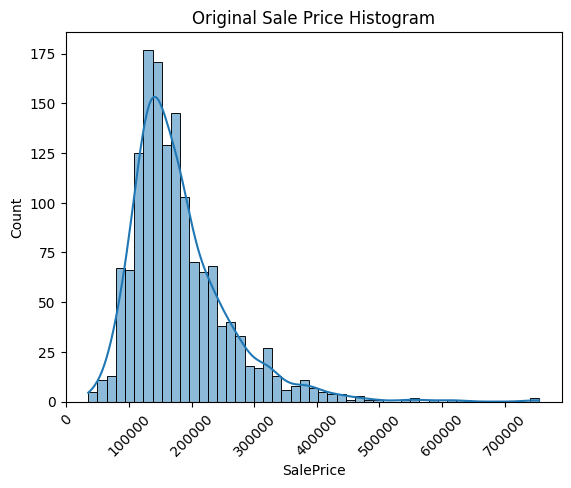

In [37]:
plt.title('Original Sale Price Histogram')
plt.xticks(rotation=45)
sns.histplot(house_df['SalePrice'], kde=True)
plt.show()

정규 분포가 아닌 결괏값을 정규 분포 형태로 반환하기 위해 로그 변환(Log Transformation)을 적용하겠다. 먼저 넘파이의 log1p()를 이용해 로그 변환한 결괏값을 기반으로 학습한 뒤, 예측 시에는 다시 결괏값을 expm1()으로 추후에 환원하면 된다. 결괏값을 로그 변환하고 다시 분포도를 살펴보겠다.

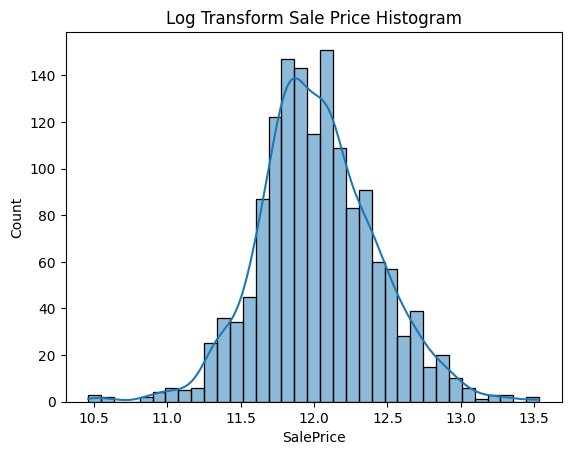

In [38]:
plt.title('Log Transform Sale Price Histogram')
log_SalePrice = np.log1p(house_df['SalePrice'])
sns.histplot(log_SalePrice, kde=True)
plt.show()

SalePrice를 로그 변환해 정규 분포 형태로 결괏값이 분포함을 확인할 수 있다. 이제 SalePrice를 로그 변환한 뒤 DataFrame에 반영하겠다.

그리고 Null 값이 많은 피처인 PoolQC, MiscFeature, Alley, Fence, FireplaceQu는 삭제하겠다. 또한 Id도 단순 식별자이므로 삭제하겠다. LotFrontage는 Null이 259개로 비교적 많으나 평균값으로 대체하겠다. 그리고 나머지 Null 피처는 Null 값이 많지 않으므로 숫자형의 경우 평균값으로 대체하겠다.

위의 로그 변환 및 Null 피처의 전처리를 수행해 보겠다. DataFrame 객체의 mean() 메서드는 자동으로 숫자형 칼럼만 추출해 칼럼별 평균값을 Series 객체로 반환해준다. 따라서 다음 코드의 DataFrame.fillna(DataFrame.mean())은 결과적으로 Null 값인 숫자형 피처만 평균값으로 대체해준다.

In [39]:
# SalePrice 로그 변환
original_SalePrice = house_df['SalePrice']
house_df['SalePrice'] = np.log1p(house_df['SalePrice'])

# Null이 너무 많은 칼럼과 불필요한 칼럼 삭제
house_df.drop(['Id', 'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu'], axis=1, inplace=True)

# 드롭하지 않는 숫자형 Null 칼럼은 평균값으로 대체
numerical_cols = house_df.select_dtypes(include=np.number).columns
house_df[numerical_cols] = house_df[numerical_cols].fillna(house_df[numerical_cols].mean())

# Null 값이 있는 피처명과 타입을 추출
null_column_count = house_df.isnull().sum()[house_df.isnull().sum() > 0]
print('## Null 피처의 Type :\n', house_df.dtypes[null_column_count.index])

## Null 피처의 Type :
 MasVnrType      object
BsmtQual        object
BsmtCond        object
BsmtExposure    object
BsmtFinType1    object
BsmtFinType2    object
Electrical      object
GarageType      object
GarageFinish    object
GarageQual      object
GarageCond      object
dtype: object


이제 문자형 피처를 제외하고는 Null 값이 없다. 문자형 피처는 모두 원-핫 인코딩으로 변환하겠다. 원—핫 인코딩은 판다스의 get_dummies()를 이용하겠다. get_dummies()는 자동으로 문자열 피처를 원-핫 인코딩 변환하면서 Null 값은 이제 문자형 피처를 제외하고는 Null 값이 없다. 문자형 피처는 모두 원-핫 인코딩으로 변환하겠다. 원-핫 인코딩은 판다스의 get_dummies()를 이용하겠다. get_dummies()는 자동으로 문자열 피처를 원-핫 인코딩 변환하면서 Null 값은 모든 인코딩 값이 0으로 변환되는 방식으로 대체해주므로 별도의 Null 값을 대체하는 로직이 필요 없다. 가령 BsmtQual 칼럼값이 'TA','Gd', 'Ex', 'FA' 외에 Null 값이 존재한다면 Null은 [0, 0, 0, 0]과 같이 BstmtQual의 4개의 종류로 만들어진 인코딩 값을 모두 0으로 하여 원-핫 인코딩 변환이 된다(4개의 값 중에 반드시 1개는 1이 되는 일반적인 원-핫 인코딩과 다르게 변환된다). 원-핫 인코딩을 적용하면 당연히 칼럼이 증가한다. 변환 후 얼마나 칼럼이 늘어났는지 확인해 보겠다. 원-핫 인코딩을 적용하면 당연히 칼럼이 증가한다. 변환 후 얼마나 칼럼이 늘어났는지 확인해 보겠다.

In [40]:
print('get_dummies() 수행 전 데이터 Shape:', house_df.shape)
house_df_ohe = pd.get_dummies(house_df)
print('get_dummies() 수행 후 데이터 Shape:', house_df_ohe.shape)

null_column_count = house_df_ohe.isnull().sum()[house_df_ohe.isnull().sum() > 0]
print('## Null 피처의 Type :\n', house_df_ohe.dtypes[null_column_count.index])

get_dummies() 수행 전 데이터 Shape: (1460, 75)
get_dummies() 수행 후 데이터 Shape: (1460, 270)
## Null 피처의 Type :
 Series([], dtype: object)


원-핫 인코딩 후 피처가 75개에서 271개로 증가했다. 그리고 Null 값을 가진 피처는 이제 존재하지 않는다. 이 정도에서 데이터 세트의 기본적인 가공은 마치고 회귀 모델을 생성해 학습한 후 예측 결과를 평가해 보겠다. 먼저 데이터 세트를 학습과 테스트 데이터 세트로 분할해 사이킷런의 LinearRegression, Ridge, Lasso를 이용해 선형 계열의 회귀 모델을 만들어 보겠다.

### 선형 회귀 모델 학습/예측/평가
앞에서 예측 평가는 RMSLE(즉, 실제 값과 예측값의 오류를 로그 변환한 뒤 RMSE를 적용)를 이용한다고 말했다. 그런데 이미 타깃 값인 SalePrice가 로그 변환됐다. 예측값 역시 로그 변환된 SalePrice 값을 기반으로 예측하므로 원본 SalePrice 예측값의 로그 변환 값이다. 실제 값도 로그 변환됐고, 예측값도 이를 반영한 로그 변환 값이므로 예측 결과 오류에 RMSE만 적용하면 RMSLE가 자동으로 측정된다(원래 캐글에서는 실제 값의 로그 변환된 값과 이에 기반한 예측값을 RMSE로 평가하도록 제시했다. 이에 대한 표현을 앞에서 RMSLE로 대체한 것이다).

여러 모델의 로그 변환된 RMSE를 측정할 것이므로 이를 계산하는 함수를 먼저 생성하겠다.

In [41]:
def get_rmse(model):
  pred = model.predict(X_test)
  mse = mean_squared_error(y_test, pred)
  rmse = np.sqrt(mse)
  print(model.__class__.__name__, '로그 변환된 RMSE:', np.round(rmse, 3))
  return rmse

def get_rmses(models):
  rmses = []
  for model in models:
    rmse = get_rmse(model)
    rmses.append(rmse)
  return rmses

get_rmse(model)은 단일 모델의 RMSE 값을, get_rmses(models)는 get_rmse()를 이용해 여러 모델의 RMSE 값을 반환한다. 이제 선형 회귀 모델을 학습하고 예측, 평가해 보겠다.

In [42]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice', axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

# LinearRegression, Ridge, Lasso 학습, 예측, 평가
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge()
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso()
lasso_reg.fit(X_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

LinearRegression 로그 변환된 RMSE: 0.132
Ridge 로그 변환된 RMSE: 0.127
Lasso 로그 변환된 RMSE: 0.176


[np.float64(0.13183184688250701),
 np.float64(0.1274058283626616),
 np.float64(0.17628250556471403)]

라쏘 회귀의 경우 회귀 성능이 타 회귀 방식보다 많이 떨어지는 결과가 나왔다. 라쏘의 경우 최적 하이퍼 파라미터 튜닝이 필요해 보인다. 조금 있다가 alpha 하이퍼 파라미터 최적화를 릿지와 라쏘 모델에 대해서 수행하겠다. 그보다 먼저 피처별 회귀 계수를 시각화해서 모델별로 어떠한 피처의 회귀 계수로 구성되는지 확인해 보겠다. 피처가 많으니 회귀 계수 값의 상위 10개, 하위 10개의 피처명과 그 회귀 계수 값을 가지는 판다스 Series 객체를 반환하는 함수를 만들겠다.

In [43]:
def get_top_bottom_coef(model, n=10):
  # coef_ 속성을 기반으로 Series 객체를 생성. index는 칼럼명.
  coef = pd.Series(model.coef_, index=X_features.columns)

  # + 상위 10개, - 하위 10개의 회귀 계수를 추출해 반환.
  coef_high = coef.sort_values(ascending=False).head(n)
  coef_low = coef.sort_values(ascending=False).tail(n)
  return coef_high, coef_low

생성한 get_top_bottom_coef(model, n=10 ) 함수를 이용해 모델별 회귀 계수를 시각화한다. 시각화를 위한 함수로 visualize_coefficient(models)를 생성한다. 해당 함수는 list 객체로 모델을 입력받아 모델별로 회귀 계수 상위 10개, 하위 10개를 추출해 가로 막대 그래프 형태로 출력한다.

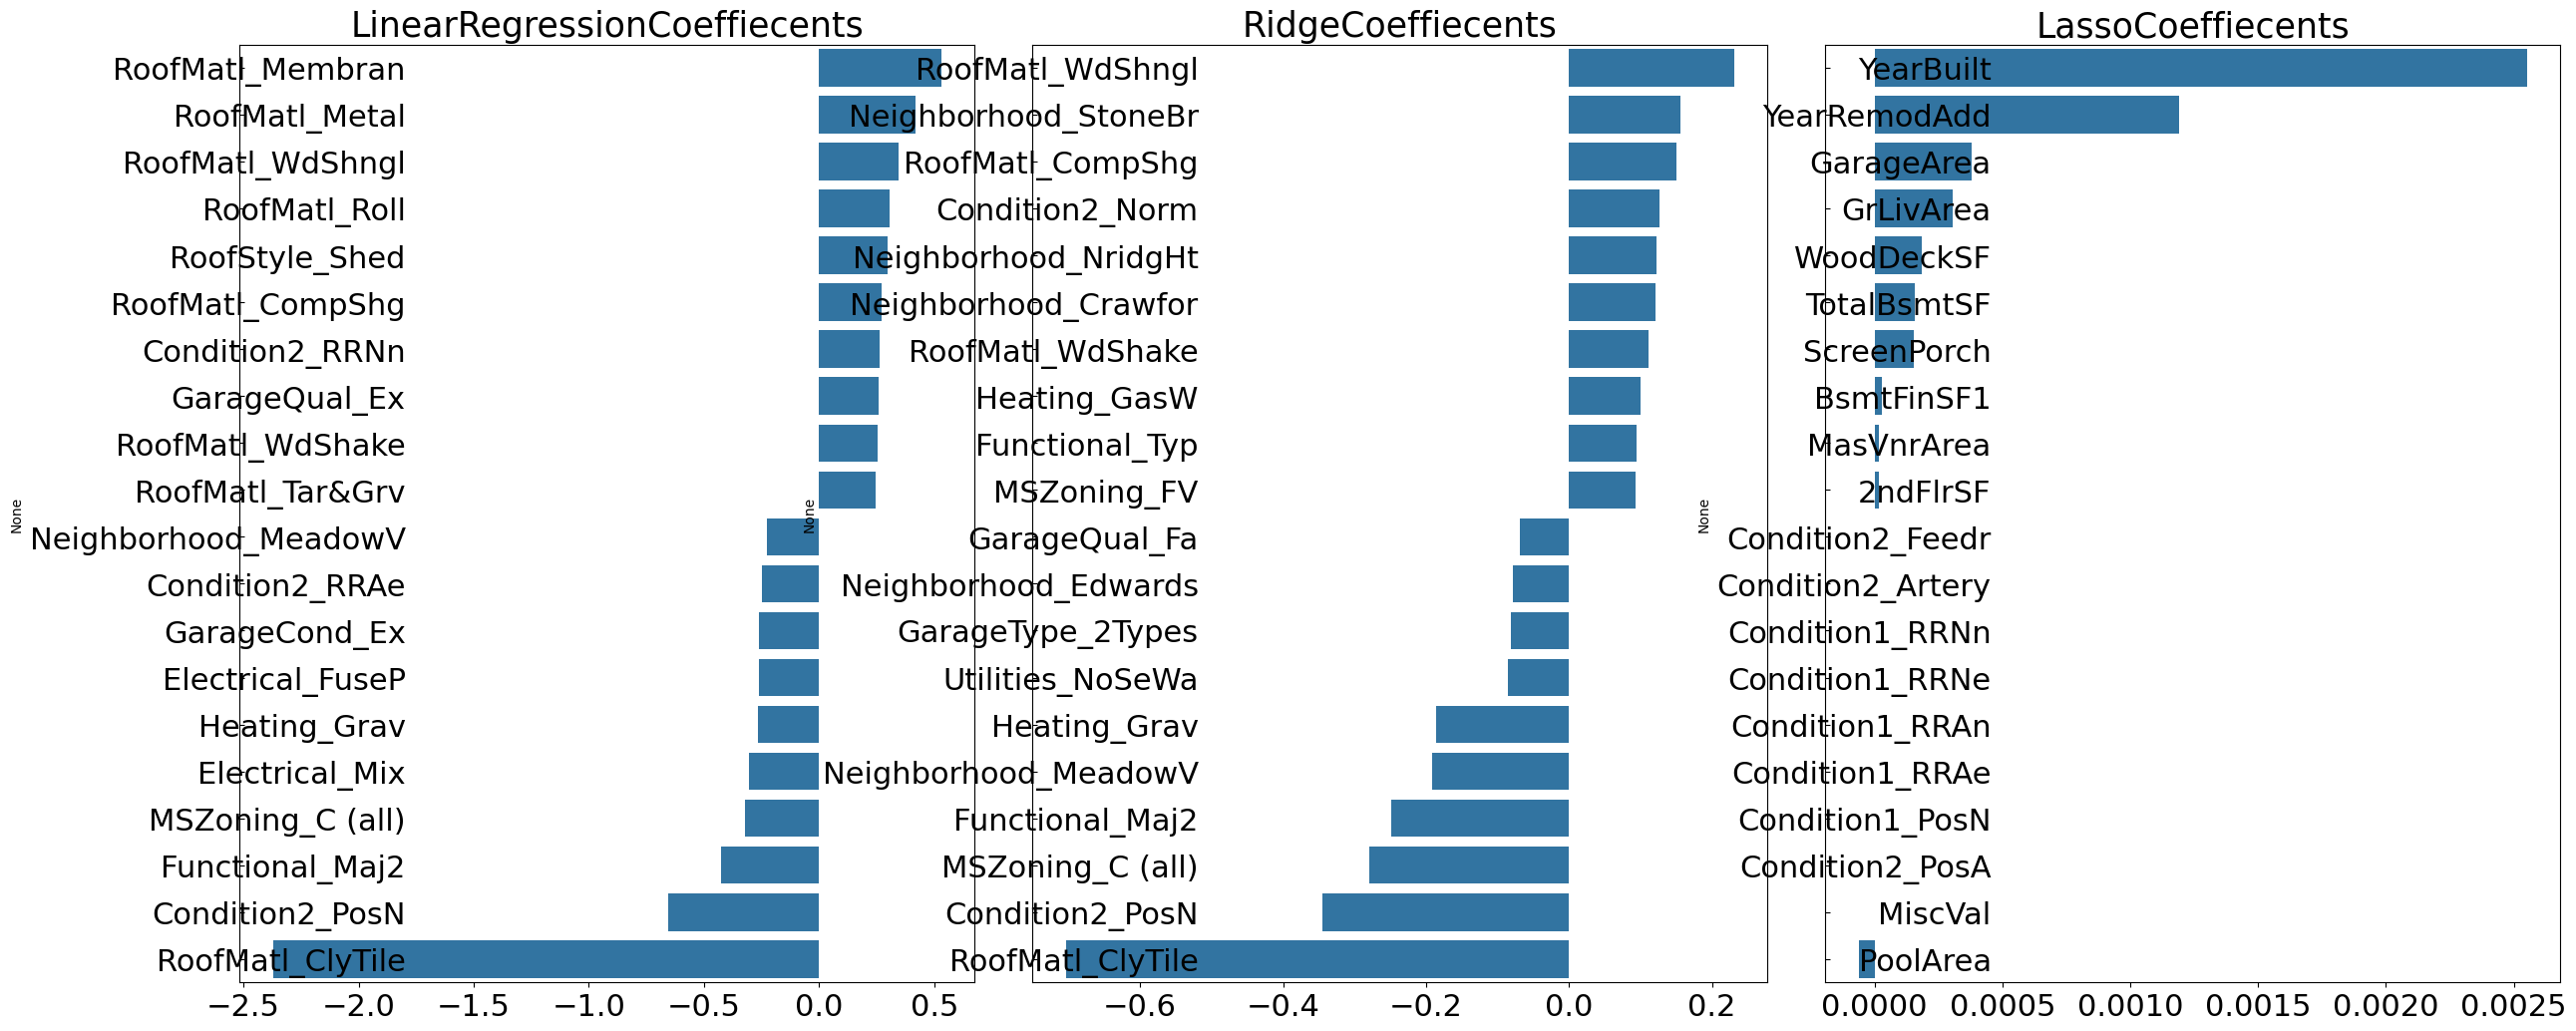

In [46]:
def visualize_coefficient(models):
  # 3개 회귀 모델의 시각화를 위해 3개의 칼럼을 가지는 subplot 생성
  fig, axs = plt.subplots(figsize=(24, 10), nrows=1, ncols=3)
  fig.tight_layout()
  # 입력 인자로 받은 list 객체인 models에서 차례로 model을 추출해 회귀 계수 시각화.
  for i_num, model in enumerate(models):
    # 상위 10개, 하위 10개 회귀 계수를 구하고, 이를 판다스 concat으로 결합
    coef_high, coef_low = get_top_bottom_coef(model)
    coef_concat = pd.concat([coef_high, coef_low])
    # ax subplot에 barchar로 표현. 한 화면에 표현하기 위해 tick label 위치와 font 크기 조정.
    axs[i_num].set_title(model.__class__.__name__+'Coeffiecents', size=25)
    axs[i_num].tick_params(axis="y", direction="in", pad=-120)
    for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
      label.set_fontsize(22)
    sns.barplot(x=coef_concat.values, y=coef_concat.index, ax=axs[i_num])

# 앞 예제에서 학습한 lr_reg, ridge_reg, lasso_reg 모델의 회귀 계수 시각화.
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

모델별 회귀 계수를 보면 OLS 기반의 LinearRegression과 Ridge의 경우는 회귀 계수가 유사한 형태로 분포돼 있다. 하지만 라쏘(Lasso)는 전체적으로 회귀 계수 값이 매우 작고, 그중에 YearBuilt가 가장 크고 다른 피처의 회귀 계수는 너무 작다. 라쏘의 경우 다른 두 개의 모델과 다른 회귀 계수 형태를 보이고 있다. 혹시 학습 데이터의 데이터 분할에 문제가 있어서 그런 것인지, 이번에는 학습과 테스트 데이터 세트를 train_test_split()으로 분할하지 않고 전체 데이터 세트인 X_features와 y_target을 5개의 교차 검증 폴드 세트로 분할해 평균 RMSE를 측정해 보겠다. 이를 위해 cross_val_score()를 이용한다.

In [47]:
from sklearn.model_selection import cross_val_score

def get_avg_rmse_cv(models):

  for model in models:
    # 분할하지 않고 전체 데이터로 cross_val_score() 수행. 모델별 CV RMSE값과 평균 RMSE 출력
    rmse_list = np.sqrt(-cross_val_score(model, X_features, y_target, scoring="neg_mean_squared_error", cv=5))
    rmse_avg = np.mean(rmse_list)
    print('\n{0} CV RMSE 값 리스트: {1}'.format(model.__class__.__name__, np.round(rmse_list,3)))
    print('{0} CV 평균 RMSE: {1}'.format(model.__class__.__name__, np.round(rmse_avg,3)))

# 앞 예제에서 학습한 ridge_reg, lasso_reg 모델의 Cv RMSE값 출력
models = [ridge_reg, lasso_reg]
get_avg_rmse_cv(models)


Ridge CV RMSE 값 리스트: [0.117 0.154 0.142 0.117 0.189]
Ridge CV 평균 RMSE: 0.144

Lasso CV RMSE 값 리스트: [0.161 0.204 0.177 0.181 0.265]
Lasso CV 평균 RMSE: 0.198


5개의 폴드 세트로 학습한 후 평가해도 여전히 라쏘의 경우 릿지 모델보다 성능이 떨어진다. 릿지와 라쏘 모델에 대해서 alpha 하이퍼 파라미터를 변화시키면서 최적 값을 도출해 보겠다. 먼저 앞으로 모델별로 최적화 하이퍼 파라미터 작업을 반복적으로 진행하므로 이를 위한 별도의 함수를 생성하겠다. print_best_params(model, params)는 모델과 하이퍼 파라미터 딕셔너리 객체를 받아 최적화 작업의 결과를 표시하는 함수이다. 이 함수를 이용해 릿지 모델과 라쏘 모델의 최적화 alpha 값을 추출하겠다.

In [49]:
from sklearn.model_selection import GridSearchCV

def print_best_params(model, params):
  grid_model = GridSearchCV(model, param_grid=params, scoring='neg_mean_squared_error', cv=5)
  grid_model.fit(X_features, y_target)
  rmse = np.sqrt(-1* grid_model.best_score_)
  print('{0} 5 CV 시 최적 평균 RMSE 값:{1}, 최적 alpha：{2}'.format(model.__class__.__name__,np.round(rmse, 4), grid_model.best_params_))

ridge_params = {'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]}
lasso_params = {'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10]}
print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값:0.1418, 최적 alpha：{'alpha': 12}
Lasso 5 CV 시 최적 평균 RMSE 값:0.142, 최적 alpha：{'alpha': 0.001}


릿지 모델의 경우 alpha가 12에서 최적 평균 RMSE가 0.1418, 라쏘 모델의 경우 alpha가 0.0이에서 최적 평균 RMSE가 0.142이다. 라쏘 모델의 경우, alpha 값 최적화 이후 예측 성능이 많이 좋아졌다. 선형 모델에 최적 alpha 값을 설정한 뒤, train_test_split()으로 분할된 학습 데이터와 테스트 데이터를 이용해 모델의 학습/예측/평가를 수행하고, 모델별 회귀 계수를 시각화해 보겠다.

LinearRegression 로그 변환된 RMSE: 0.132
Ridge 로그 변환된 RMSE: 0.124
Lasso 로그 변환된 RMSE: 0.12


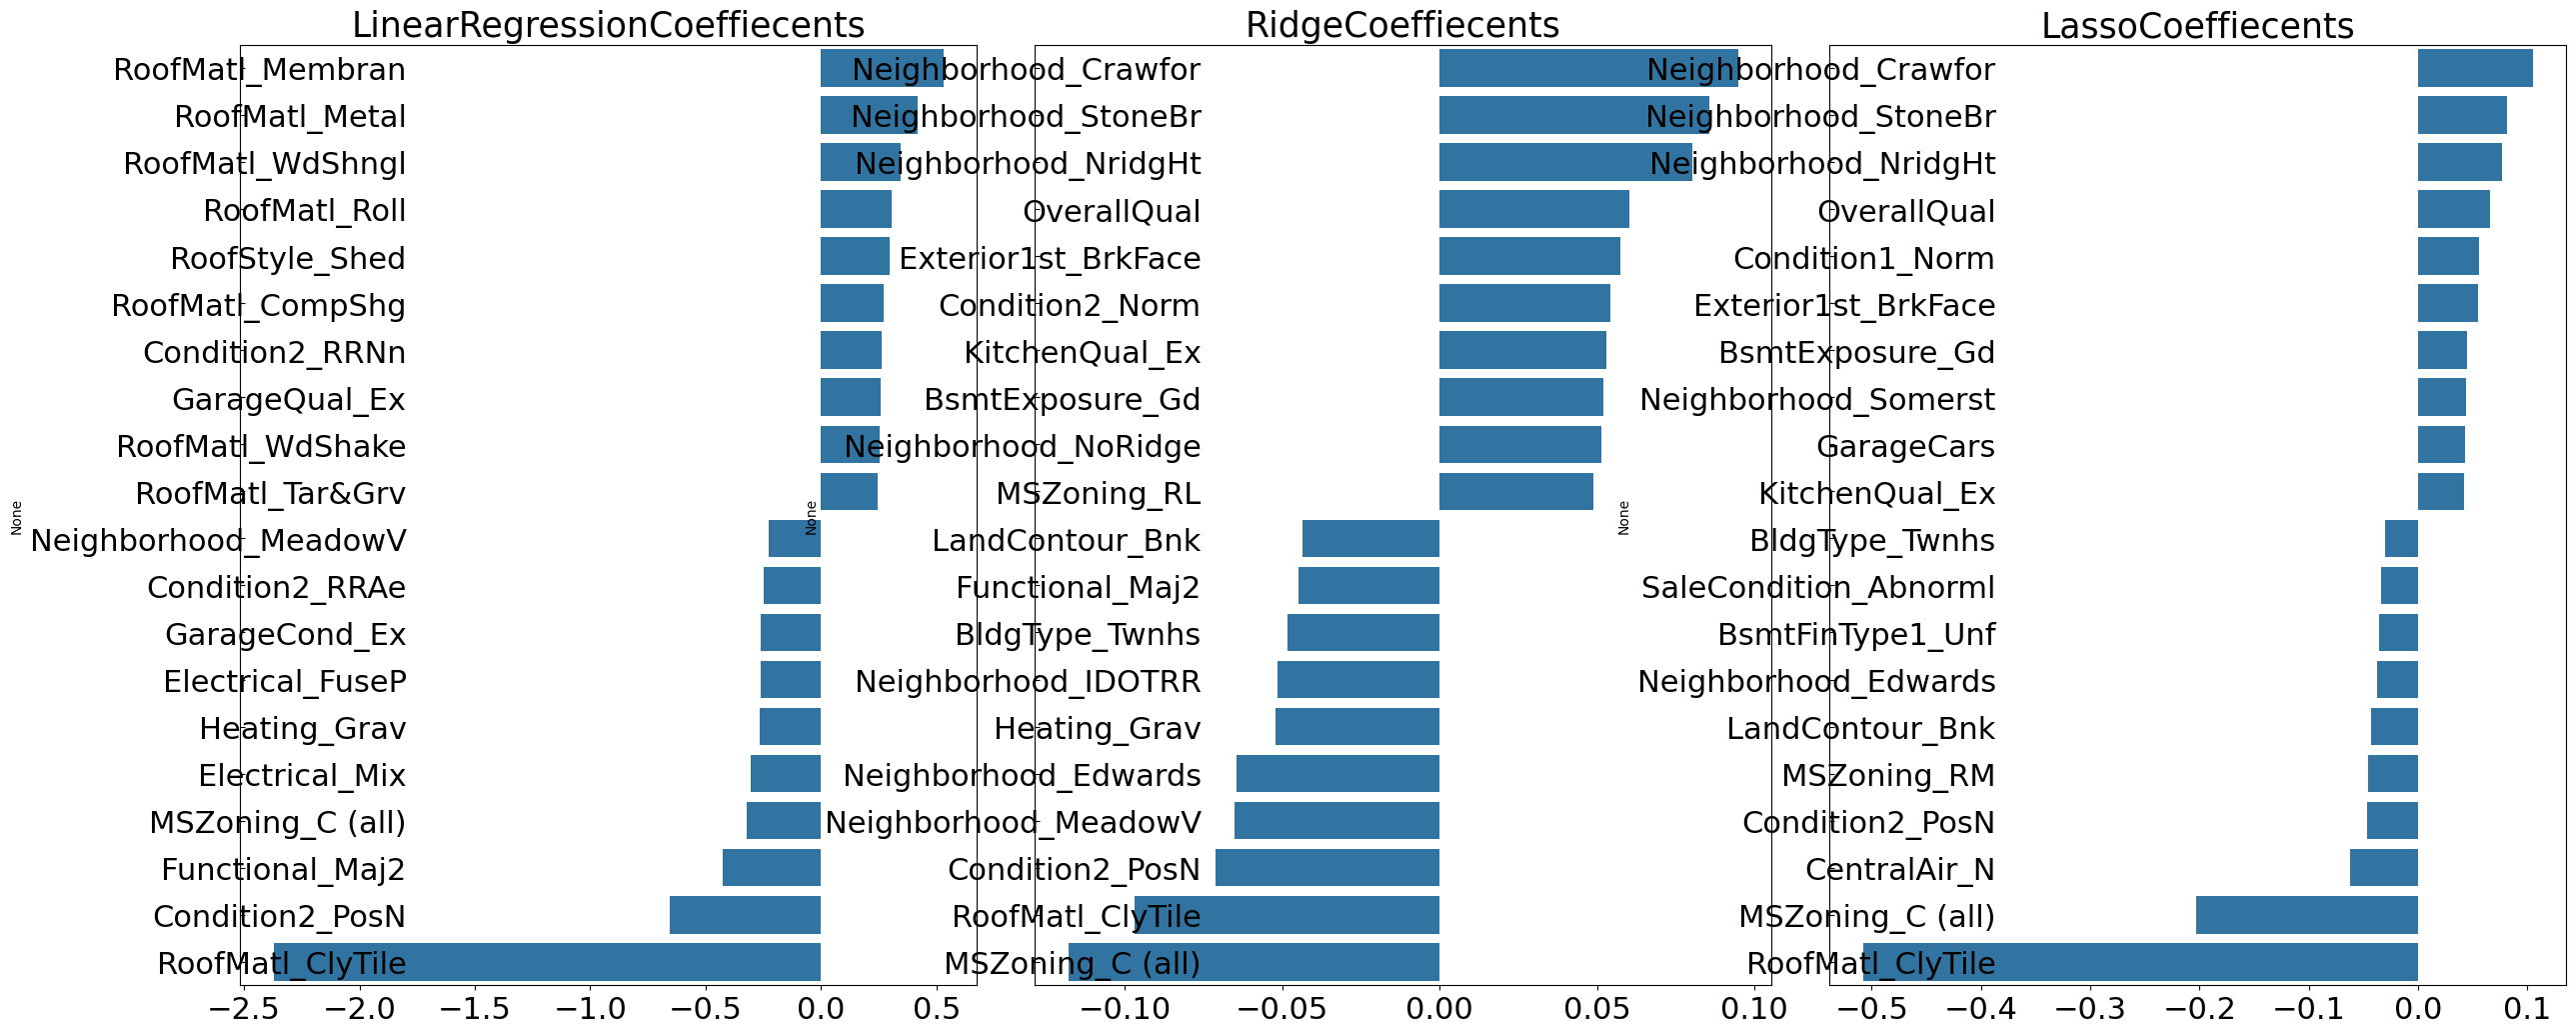

In [50]:
# 앞의 최적화 alpha 값으로 학습 데이터로 학습, 테스트 데이터로 예측 및 평가 수행.
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=12)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

# 모든 모델의 RMSE 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

# 모든 모델의 회귀 계수 시각화
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

alpha 값 최적화 후 테스트 데이터 세트의 예측 성능이 더 좋아졌다. 모델별 회귀 계수도 많이 달라 졌다. 기존에는 라쏘 모델의 회귀 계수가 나머지 두 개 모델과 많은 차이가 있었지만, 이번에는 릿지와 라쏘 모델에서 비슷한 피처의 회귀 계수가 높다. 다만 라쏘 모델의 경우는 릿지에 비해 동일한 피처라도 회귀 계수의 값이 상당히 작다.

데이터 세트를 추가적으로 가공해서 모델 튜닝을 좀 더 진행해 보겠다. 두 가지를 살펴볼 텐데, 첫 번째는 피처 데이터 세트의 데이터 분포도이고 두 번째는 이상치(Outlier) 데이터 처리이다. 먼저 피처 데이터 세트의 분포도를 확인한다.

예제의 맨 처음에서 타깃 데이터 세트의 데이터 분포도의 왜곡을 확인했다. 피처 데이터 세트의 경우도 지나치게 왜곡된 피처가 존재할 경우 회귀 예측 성능을 저하시킬 수 있다. 모든 숫자형 피처의 데이터 분포도를 확인해 분포도가 어느 정도로 왜곡됐는지 알아보겠다.

사이파이 stats 모듈의 skew() 함수를 이용해 칼럼의 데이터 세트의 왜곡된 정도를 쉽게 추출할 수 있다. DataFrame에서 숫자형 피처의 왜곡 정도를 확인해 보겠다. 일반적으로 skew() 함수의 반환 값이 1 이상인 경우를 왜곡 정도가 높다고 판단하지만 상황에 따라 편차는 있다. 여기서는 1 이상의 값을 반환하는 피처만 추출해 왜곡 정도를 완화하기 위해 로그 변환을 적용하겠다. 다음 예제 코드에서는 숫자형 피처의 칼럼 index 객체를 추출해 구한 숫자형 칼럼 데이터 세트의 apply lambda 식 skew()를 호출해 숫자형 피처의 왜곡 정도를 구한다.

여기서 한 가지 주의할 점이 있다. skew()를 적용하는 숫자형 피처에서 원-핫 인코딩된 카테고리 숫자형 피처는 제외해야 한다. 카테고리 피처는 코드성 피처이므로 인코딩 시 당연히 왜곡될 가능성이 높다(예를 들어 '화장실 여부'가 1로 1000건, 0으로 10건이 될 수 있지만, 이는 왜곡과는 무관하다). 따라서 skew() 함수를 적용하는 DataFrame은 원-핫 인코딩 이 적용된 house_df_ohe가 아니라 원-핫 인코딩이 적용되지 않은 house_df이어야 한다.

In [51]:
from scipy.stats import skew

# object가 아닌 숫자형 피처의 칼럼 index 객체 추출.
features_index = house_df.dtypes[house_df.dtypes != 'object'].index
# house_df에 칼럼 index를 []로 입력하면 해당하는 칼럼 데이터 세트 반환. apply lambda로 skew() 호출
skew_features = house_df[features_index].apply(lambda x : skew(x))
# skew(왜곡) 정도가 1 이상인 칼럼만 추출.
skew_features_top = skew_features[skew_features > 1 ]
print(skew_features_top.sort_values(ascending=False))

MiscVal          24.451640
PoolArea         14.813135
LotArea          12.195142
3SsnPorch        10.293752
LowQualFinSF      9.002080
KitchenAbvGr      4.483784
BsmtFinSF2        4.250888
ScreenPorch       4.117977
BsmtHalfBath      4.099186
EnclosedPorch     3.086696
MasVnrArea        2.673661
LotFrontage       2.382499
OpenPorchSF       2.361912
BsmtFinSF1        1.683771
WoodDeckSF        1.539792
TotalBsmtSF       1.522688
MSSubClass        1.406210
1stFlrSF          1.375342
GrLivArea         1.365156
dtype: float64


이제 추출된 왜곡 정도가 높은 피처를 로그 변환한다.

In [53]:
house_df[skew_features_top.index] = np.log1p(house_df[skew_features_top.index])

로그 변환 후 이 피처들의 왜곡 정도를 다시 확인해 보면 여전히 높은 왜곡 정도를 가진 피처가 있지만, 더 이상 로그 변환을 하더라도 개선하기는 어렵기에 그대로 유지한다. house_df의 피처를 일부 로그 변환했으므로 다시 원-핫 인코딩을 적용한 house_df_ohe를 만들겠다. 그리고 이에 기반한 피처 데이터 세트와 타깃 데이터 세트, 학습/테스트 데이터 세트를 모두 다시 만들겠다. 그리고 이렇게 만든 데이터 세트에 다시 앞에서 생성한 print_best_params() 함수를 이용해 최적 alpha 값과 RMSE를 출력해 보겠다.

In [54]:
# 왜곡 정도가 높은 피처를 로그 변환했으므로 다시 원-핫 인코딩을 적용하고 피처/타깃 데이터 세트 생성
house_df_ohe = pd.get_dummies(house_df)
y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice', axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

# 피처를 로그 변환한 후 다시 최적 하이퍼 파라미터와 RMSE 출력
ridge_params = {'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]}
lassojoarams = {'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10]}
print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값:0.1275, 최적 alpha：{'alpha': 10}
Lasso 5 CV 시 최적 평균 RMSE 값:0.1252, 최적 alpha：{'alpha': 0.001}


릿지 모델의 경우 최적 alpha값이 12에서 10으로 변경됐고, 두 모델 모두 피처의 로그 변환 이전과 비교해 릿지의 경우 0.1418에서 0.1275로, 라쏘의 경우 0.142에서 0.1252로, 5 폴드 교차 검증의 평균 RMSE값이 향상됐다. 다시 위의 train_test_split()으로 분할된 학습 데이터와 테스트 데이터를 이용해 모델의 학습/예측/평가 및 모델별 회귀 계수를 시각화하면 결과는 다음과 같다. 회귀 계수 시각화 결과를 보면 세 모델 모두 GrLivArea, 즉 주거 공간 크기가 회귀 계수가 가장 높은 피처가 됐다. 주거 공간의 크기가 주택 가격에 미치는 영향이 당연히 제일 높을 것이라는 상식선에서의 결과가 이제야 도출됐다.

다음으로 좀 더 분석할 요소는 이상치 데이터이다. 특히 회귀 계수가 높은 피처, 즉 예측에 많은 영향을 미치는 중요 피처의 이상치 데이터의 처리가 중요하다. 먼저 세 개 모델 모두에서 가장 큰 회귀 계수를 가지는 GrLivArea 피처의 데이터 분포를 살펴보겠다.

주택 가격 데이터가 변환되기 이전의 원본 데이터 세트인 house_df_org에서 GrLivArea와 타깃 값인 SalePrice의 관계를 시각화해 보겠다(house_df_org 객체 변수는 이 예제의 맨 처음 시작 부분에서 찾을 수 있다).

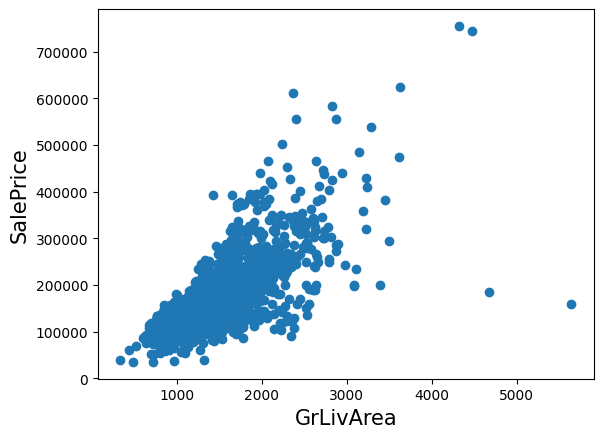

In [55]:
plt.scatter(x=house_df_org['GrLivArea'], y=house_df_org['SalePrice'])
plt.ylabel('SalePrice', fontsize=15)
plt.xlabel('GrLivArea', fontsize=15)
plt.show()

일반적으로 주거 공간이 큰 집일수록 가격이 비싸기 때문에 GrLivArea 피처는 SalePrice와 양의 상관도가 매우 높음을 직관적으로 알 수 있다. 하지만 위 그림에서 네모로 표시한 2개의 데이터는 일반적인 GrLivArea와 SalePrice 관계에서 너무 어긋나 있다. 두 데이터의 GrLivArea가 가장 큰 데도 불구하고 가격은 매우 낮다. GrLivArea가 4000평방피트 이상임에도 가격이 500,000달러 이하인 데이터는 모두 이상치로 간주하고 삭제하겠다.

데이터 변환이 모두 완료된 house_df_ohe에서 대상 데이터를 필터링하겠다. GrLivArea와 SalePrice 모두 로그 변환됐으므로 이를 반영한 조건을 생성한 뒤, 불린 인덱싱으로 대상을 찾는다. 찾은 데이터의 DataFrame 인덱스와 drop()을 이용해 해당 데이터를 삭제한다.

In [56]:
# GrLivArea와 SalePrice 모두 로그 변환됐으므로 이를 반영한 조건 생성 .
cond1 = house_df_ohe['GrLivArea'] > np.log1p(4000)
cond2 = house_df_ohe['SalePrice'] < np.log1p(500000)
outlier_index = house_df_ohe[cond1 & cond2].index

print('이상치 레코드 index :',outlier_index.values)
print('이상치 삭제 전 house_df_ohe shape :',house_df_ohe.shape)

# DataFrame의 인덱스를 이용해 이상치 레코드 삭제.
house_df_ohe.drop(outlier_index, axis=0, inplace=True)
print('이상치 삭제 후 house_df_ohe shape :',house_df_ohe.shape)

이상치 레코드 index : [ 523 1298]
이상치 삭제 전 house_df_ohe shape : (1460, 270)
이상치 삭제 후 house_df_ohe shape : (1458, 270)


레코드 인덱스 523, 1298이 대상이며 두 개의 데이터를 삭제해 전체 레코드는 1460개에서 1458개로 줄었다. 업데이트된 house_df_ohe를 기반으로 피처 데이터 세트와 타깃 데이터 세트를 다시 생성하고 앞에서 정의한 print_best_params() 함수를 이용해 릿지와 라쏘 모델의 최적화를 수행하고 결과를 출력해 보겠다.

In [58]:
y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice', axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

ridge_params = {'alpha' :[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]}
lasso_params = {'alpha' :[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10]}
print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값:0.1125, 최적 alpha：{'alpha': 8}
Lasso 5 CV 시 최적 평균 RMSE 값:0.1122, 최적 alpha：{'alpha': 0.001}


단 두 개의 이상치 데이터만 제거했는데, 예측 수치가 매우 크게 향상됐다. 그리고 릿지 모델의 경우 최적 alpha 값은 12에서 8로 변했고, 평균 RMSE가 0.1275에서 0.1125로 개선됐다. 라쏘 모델의 경우는 평균 RMSE가 0.1252에서 0.1122로 개선됐다. 라쏘 모델의 경우 RMSE가 약 0.128에서 약 0.114로 매우 낮아졌다. 웬만큼 하이퍼 파라미터 튜닝을 해도 이 정도의 수치 개선은 어렵다. GrLivArea 속성이 회귀 모델에서 차지하는 영향도가 크기에 이 이상치를 개선하는 것이 성능 개선에 큰 의미를 가졌다.

이상치를 찾는 것은 쉽지 않지만, 회귀에 중요한 영향을 미치는 피처를 위주로 이상치 데이터를 찾으려는 노력은 중요하다. 보통 머신러닝 프로세스 중에서 데이터의 가공은 알고리즘을 적용하기 이전에 수행한다. 하지만 이것이 머신러닝 알고리즘을 적용하기 이전에 완벽하게 데이터의 선처리 작업을 수행하라는 의미는 아니다. 일단 대략의 데이터 가공과 모델 최적화를 수행한 뒤 다시 이에 기반한 여러 가지 기법의 데이터 가공과 하이퍼 파라미터 기반의 모델 최적화를 반복적으로 수행하는 것이 바람직한 머신러닝 모델 생성 과정이다.

이상치가 제거된 데이터 세트를 기반으로 다시 train_test_split()로 분할된 데이터 세트의 RMSE 수치 및 회귀 계수를 시각화한 결과는 다음과 같다.

### 회귀 트리 모델 학습/예측/평가
이번에는 회귀 트리를 이용해 회귀 모델을 만들어 보겠다. XGBoost는 XGBRegressor 클래스를, LightGBm은 LGBMGrgressor 클래스를 이용한다. XGBoost, LightGBM 모두 수행 시간이 오래 걸릴 수 있는 관계로 다음과 같은 하이퍼 파라미터 설정을 미리 적용한 상태로 5 폴드 세트에 대한 평균 RMSE 값을 구하겠다.

In [59]:
from xgboost import XGBRegressor
xgb_params = {'n_estimators' : [1000]}
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05, colsample_bytree=0.5, subsample=0.8)
print_best_params(xgb_reg, xgb_params)

XGBRegressor 5 CV 시 최적 평균 RMSE 값:0.1206, 최적 alpha：{'n_estimators': 1000}


XGBoost 회귀 트리를 적용했을 때 5 폴드 세트 평균 RMSE가 약 0.1178이다. 이번에는 LightGBM 회귀 트리를 적용해 보겠다.

In [60]:
from lightgbm import LGBMRegressor
lgbm_params = {'n_estimators' : [1000]}
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4, subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)
print_best_params(lgbm_reg, lgbm_params)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000799 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3155
[LightGBM] [Info] Number of data points in the train set: 1166, number of used features: 171
[LightGBM] [Info] Start training from score 12.021352
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000809 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3167
[LightGBM] [Info] Number of data points in the train set: 1166, number of used features: 168
[LightGBM] [Info] Start training from score 12.023516
[LightGBM] [Warning] Found

LightGBM 적용 시 5 폴드 세트 평균 RMSE가 약 0.1163이다. 이 모델의 피처 중요도를 시각화해 보겠다.

### 회귀 모델의 예측 결과 혼합을 통한 최종 예측
이번에는 개별 회귀 모델의 예측 결괏값을 혼합해 이를 기반으로 최종 회귀 값을 예측하겠다. 기본적으로 예측 결과 혼합은 매우 간단하다. 가령 A 모델과 B 모델, 두 모델의 예측값이 있다면 A 모델 예측값의 40%, B 모델 예측값의 60%를 더해서 최종 회귀 값으로 예측하는 것이다. A 회귀 모델의 예측값이 [100, 80, 60]이고, B 회귀 모델의 예측값이 [120, 80, 50]이라면 최종 회귀 예측값은 [100*0.4 + 120*0.6, 80*0.4 + 80*0.6, 60*0.4 + 50*0.6] = [112, 80, 54]가 됩니다. 앞에서 구한 릿지 모델과 라쏘 모델을 서로 혼합해 보겠다. 최종 혼합 모델, 개별 모델의 RMSE 값을 출력하는 get_rmse_pred() 함수를 생성하고 각 모델의 예측값을 계산한 뒤 개별 모델과 최종 혼합 모델의 RMSE 를 구한다.

In [61]:
def get_rmse_pred(preds):
  for key in preds.keys():
    pred_value = preds[key]
    mse = mean_squared_error(y_test, pred_value)
    rmse = np.sqrt(mse)
    print('{0} 모델의 RMSE： {1}'.format(key, rmse))

# 개별 모델의 학습
ridge_reg = Ridge(alpha=8)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)
# 개별 모델 예측
ridge_pred = ridge_reg.predict(X_test)
lasso_pred = lasso_reg.predict(X_test)

# 개별 모델 예측값 혼합으로 최종 예측값 도출
pred = 0.4 * ridge_pred + 0.6 * lasso_pred
preds = {'최종 혼합':pred, 'Ridge':ridge_pred, 'Lasso':lasso_pred}

# 최종 혼합 모델, 개별 모델의 RMSE 값 출력
get_rmse_pred(preds)

최종 혼합 모델의 RMSE： 0.10006075517615193
Ridge 모델의 RMSE： 0.10340697165289348
Lasso 모델의 RMSE： 0.10024171179335342


최종 혼합 모델의 RMSE가 개별 모델보다 성능 면에서 약간 개선됐다. 릿지 모델 예측값에 0.4를 곱하고 라쏘 모델 예측값에 0.6을 곱한 뒤 더했다. 0.4나 0.6을 정하는 특별한 기준은 없다. 두 개 중 성능이 조금 좋은 쪽에 가중치를 약간 더 뒀다. 이번에는 XGBoost와 LightGBM을 혼합해 결과를 살펴보겠다.

In [63]:
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05, colsample_bytree=0.5, subsample=0.8)
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4, subsample=0.6, colsample_bytree=0.4, reg_lambda=10, njobs=-1)
xgb_reg.fit(X_train, y_train)
lgbm_reg.fit(X_train, y_train)
xgb_pred = xgb_reg.predict(X_test)
lgbm_pred = lgbm_reg.predict(X_test)
pred = 0.5 * xgb_pred + 0.5 * lgbm_pred
preds = {'최종 혼합': pred, 'XGBM': xgb_pred, 'LGBM': lgbm_pred}

get_rmse_pred(preds)

[LightGBM] [Warning] Unknown parameter: njobs
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: njobs
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005507 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3174
[LightGBM] [Info] Number of data points in the train set: 1166, number of used features: 172
[LightGBM] [Info] Start training from score 12.025343
[LightGBM] [Warning] Unknown parameter: njobs
최종 혼합 모델의 RMSE： 0.10215383402419025
XGBM 모델의 RMSE： 0.10761344291735733
LGBM 모델의 RMSE： 0.10363891833477148


XGBoost와 LightGBM의 혼합 모델의 RMSE가 개별 모델의 RMSE보다 조금 향상됐다.

### 스태킹 앙상블 모델을 통한 회귀 예측
4장 분류에서 소개한 스태킹 모델을 회귀에도 적용할 수 있다. 먼저 스태킹 모델의 구현 방법을 다시 정리하겠다. 스태킹 모델은 두 종류의 모델이 필요하다. 첫 번째는 개별적인 기반 모델이고, 두 번째 이 개별 기반 모델의 예측 데이터를 학습 데이터로 만들어서 학습하는 최종 메타 모델이다. 스태킹 모델의 핵심은 여러 개별 모델의 예측 데이터를 각각 스태킹 형태로 결합해 최종 메타 모델의 학습용 피처 데이터 세트와 테스트용 피처 데이터 세트를 만드는 것이다.

최종 메타 모델이 학습할 피처 데이터 세트는 원본 학습 피처 세트로 학습한 개별 모델의 예측값을 스태킹 형태로 결합한 것이다. 이미 4장에서 소개 했지만, 개별 모델을 스태킹 모델로 제공하기 위해 데이터 세트를 생성하기 위한 get_stackingj3ase_datasets() 함수이다. 기억을 되살리기 위해 다시 한번 책에 수록했다.

In [64]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# 개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수.
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds):
  # 지정된 n_folds값으로 KFold 생성.
  kf = KFold(n_splits=n_folds, shuffle=False)
  # 추후에 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화
  train_fold_pred = np.zeros((X_train_n.shape[0], 1))
  test_pred = np.zeros((X_test_n.shape[0], n_folds))
  print(model.__class__.__name__, 'model 시작')
  for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train_n)):
    # 입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 세트 추출
    print('\t 폴드 세트: ',folder_counter, ' 시작 ')
    X_tr = X_train_n[train_index]
    y_tr = y_train_n[train_index]
    X_te = X_train_n[valid_index]

    # 폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행.
    model.fit(X_tr, y_tr)
    # 폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장.
    train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1, 1)
    # 입력된 원본 테스트 데이터를 폴드 세트 내 학습된 기반 모델에서 예측 후 데이터 저장.
    test_pred[:, folder_counter] = model.predict(X_test_n)

  # 폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성
  test_pred_mean = np.mean(test_pred, axis=1).reshape(-1, 1)

  # train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
  return train_fold_pred, test_pred_mean

get_stacking_base_datasets()는 인자로 개별 기반 모델, 그리고 원래 사용되는 학습 데이터와 테스트용 피처 데이터를 입력받는다. 함수 내에서는 개별 모델이 K-폴드 세트로 설정된 폴드 세트 내부에서 원본의 학습 데이터를 다시 추출해 학습과 예측을 수행한 뒤 그 결과를 저장한다. 저장된 예측 데이터는 추후에 메타 모델의 학습 피처 데이터 세트로 이용된다. 또한 함수 내에서 폴드 세트 내부 학습 데이터로 학습된 개별 모델이 인자로 입력된 원본 테스트 데이터를 예측한 뒤, 예측 결과를 평균해 테스트 데이터로 생성한다.

이제 get_stacking_base_datasets()를 모델별로 적용해 메타 모델이 사용할 학습 피처 데이터 세트와 테스트 피처 데이터 세트를 추출하겠다. 적용할 개별 모델은 릿지, 라쏘, XGBoost, LightGBM의 총 4개이다.

In [65]:
# get_stacking_base_datasets( )는 넘파이 ndarray를 인자로 사용하므로 DataFrame을 넘파이로 변환.
X_train_n = X_train.values
X_test_n = X_test.values
y_train_n = y_train.values

# 각 개별 기반(Base) 모델이 생성한 학습용/테스트용 데이터 반환.
ridge_train, ridge_test = get_stacking_base_datasets(ridge_reg, X_train_n, y_train_n, X_test_n, 5)
lasso_train, lasso_test = get_stacking_base_datasets(lasso_reg, X_train_n, y_train_n, X_test_n, 5)
xgb_train, xgb_test = get_stacking_base_datasets(xgb_reg, X_train_n, y_train_n, X_test_n, 5)
lgbm_train, lgbm_test = get_stacking_base_datasets(lgbm_reg, X_train_n, y_train_n, X_test_n, 5)

Ridge model 시작
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
Lasso model 시작
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
XGBRegressor model 시작
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
LGBMRegressor model 시작
	 폴드 세트:  0  시작 
[LightGBM] [Warning] Unknown parameter: njobs
[LightGBM] [Warning] Unknown parameter: njobs
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000804 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2924
[LightGBM] [Info] Number of data points in the train set: 932, number of used features: 156
[LightGBM] [Info] Start training from score 12.035561
[LightGBM] [Warning] Unknown parameter: njobs
[LightGBM] [Warning] Unknown parameter: njobs
	 폴드 세트:  1  시작 
[LightGBM] [Warning] Unknown parameter: njobs


각 개별 모델이 반환하는 학습용 피처 데이터와 테스트용 피처 데이터 세트들 결합해 최종 메타 모델에 적용해 보겠다. 메타 모델은 별도의 라쏘 모델을 이용하며, 최종적으로 예측 및 RMSE를 측정한다.

In [67]:
# 개별 모델이 반환한 학습 및 테스트용 데이터 세트를 스태킹 형태로 결합.
Stack_final_X_train = np.concatenate((ridge_train, lasso_train, xgb_train, lgbm_train), axis=1)
Stack_final_X_test = np.concatenate((ridge_test, lasso_test, xgb_test, lgbm_test), axis=1)

# 최종 메타 모델은 라쏘 모델을 적용.
meta_model_lasso = Lasso(alpha=0.0005)

# 개별 모델 예측값을 기반으로 새롭게 만들어진 학습/테스트 데이터로 메타 모델 예측 및 RMSE 측정.
meta_model_lasso.fit(Stack_final_X_train, y_train)
final = meta_model_lasso.predict(Stack_final_X_test)
mse = mean_squared_error(y_test, final)
rmse = np.sqrt(mse)
print('스태킹 회귀 모델의 최종 RMSE 값은:', rmse)

스태킹 회귀 모델의 최종 RMSE 값은: 0.09704503149148055


최종적으로 스태킹 회귀 모델을 적용할 결과, 테스트 데이터 세트에서 RMSE가 약 0.0979로 현재까지 가장 좋은 성능 평가를 보여준다. 스태킹 모델은 분류뿐만 아니라 회귀에서 특히 효과적으로 사용될 수 있는 모델이다.